In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from src.bioreactor import *

In [9]:
# Check if ../models/simple_nn.pkl exists
# If it does, load the model; if not, train the model and save it
try:
    model = pickle.load(open('./models/simple_nn.pkl', 'rb'))
except FileNotFoundError:
    X_train, y_train = generate_training_data()

    model = MLPRegressor(hidden_layer_sizes=(256,256), learning_rate='adaptive',  
                        learning_rate_init=0.001, max_iter=1000, tol=1e-6, activation='relu', 
                        batch_size=256, early_stopping=True, verbose=True)   
    model.fit(X_train, y_train)
    pickle.dump(model, open('./models/simple_nn.pkl', 'wb'))

In [10]:
X, S, V, F = mpc(model='discretized')
# X, S, V, F = mpc_pso(model)
# X, S, V, F = mpc_diff_evol(model)
# X, S, V, F = mpc(model)

 29%|██▉       | 116/400 [00:01<00:04, 62.88it/s]

 36%|███▋      | 145/400 [00:02<00:05, 47.44it/s]

 41%|████      | 163/400 [00:02<00:05, 43.68it/s]

 47%|████▋     | 188/400 [00:02<00:03, 60.71it/s]

 50%|████▉     | 198/400 [00:03<00:05, 34.94it/s]

 59%|█████▉    | 237/400 [00:04<00:02, 60.10it/s]

 65%|██████▌   | 260/400 [00:04<00:01, 72.70it/s]

 80%|████████  | 320/400 [00:04<00:00, 156.65it/s]

100%|██████████| 400/400 [00:04<00:00, 82.52it/s] 


Maximum biomass concentration: 76.82 g/l at time 38.00 hours


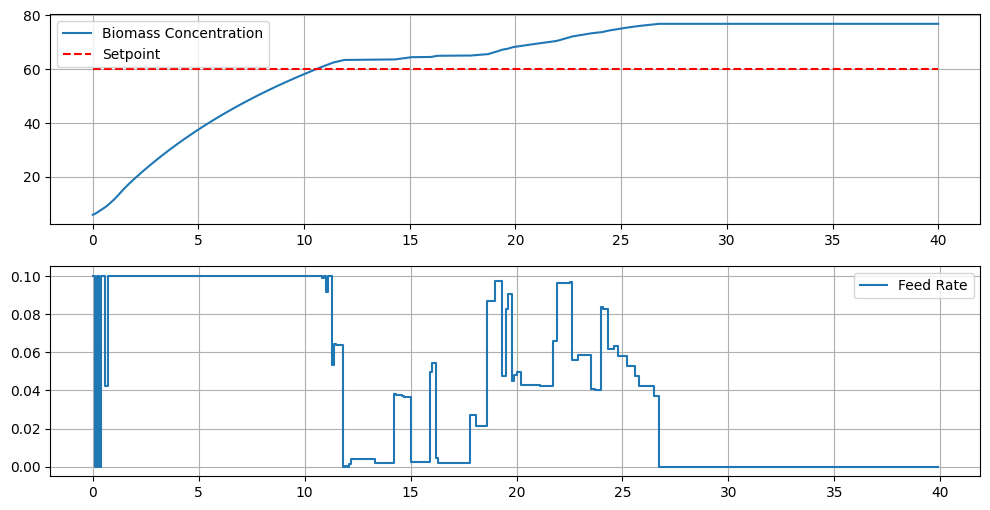

In [11]:
plot_results(X, F)

Maximum biomass concentration: 76.73 g/l at time 28.10 hours


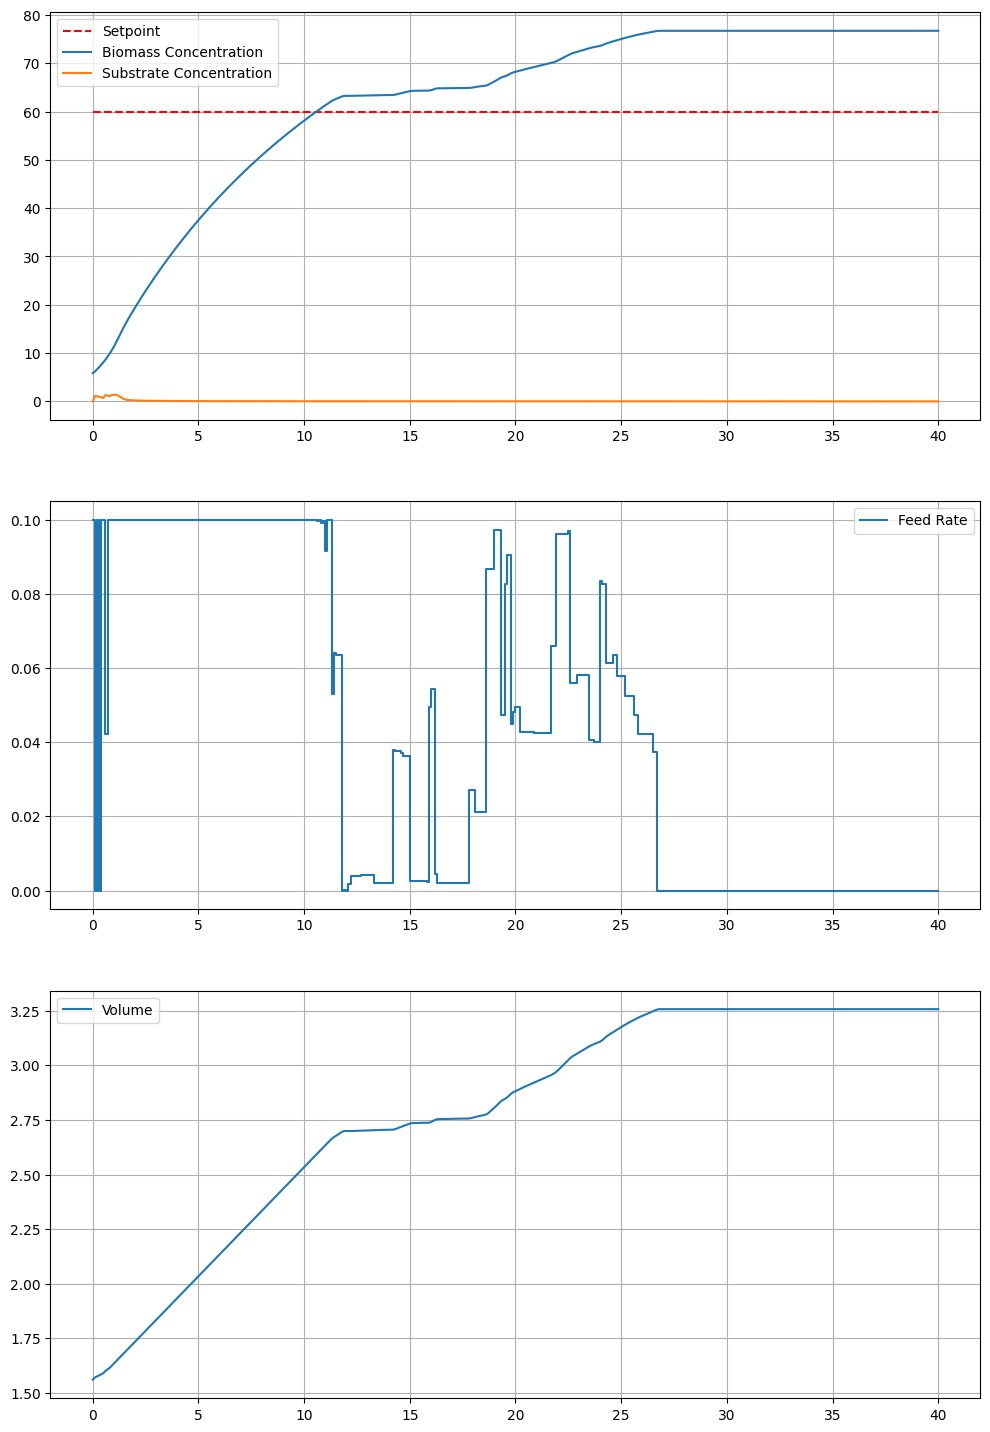

In [12]:
evaluation(F)